In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import anndata as ad

## preprocess both files supplied in GEO in bash

## read in sample/cell info

In [7]:
pts = pd.read_table("/localdata/rna_rep_learning/sadefeldman/GSE120575_processed_metadata.txt")

In [8]:
pts['characteristics: therapy'].value_counts()

anti-PD1          11653
anti-CTLA4+PD1     4121
anti-CTLA4          517
Name: characteristics: therapy, dtype: int64

#### drop empty columns

In [9]:
#check that all are empty
(~pts.loc[:,'molecule':'Unnamed: 34'].isna()).sum() 

molecule                0
description             0
processed data file     0
raw file                0
Unnamed: 11             0
Unnamed: 12             0
Unnamed: 13             0
Unnamed: 14             0
Unnamed: 15             0
Unnamed: 16             0
Unnamed: 17             0
Unnamed: 18             0
Unnamed: 19             0
Unnamed: 20             0
Unnamed: 21             0
Unnamed: 22             0
Unnamed: 23             0
Unnamed: 24             0
Unnamed: 25             0
Unnamed: 26             0
Unnamed: 27             0
Unnamed: 28             0
Unnamed: 29             0
Unnamed: 30             0
Unnamed: 31             0
Unnamed: 32             0
Unnamed: 33             0
Unnamed: 34             0
dtype: int64

In [10]:
# drop
pts.drop(columns=pts.columns[7:], inplace=True)

In [11]:
len(pd.unique(pts.title))

16291

## clean up column names, drop meaningless columns

In [12]:
pts.drop(columns=["Sample name","organism","source name"], inplace=True)

In [13]:
pts.columns

Index(['title',
       'characteristics: patinet ID (Pre=baseline; Post= on treatment)',
       'characteristics: response', 'characteristics: therapy'],
      dtype='object')

In [14]:
pts.rename(columns={'title':'cellid',
       'characteristics: patinet ID (Pre=baseline; Post= on treatment)':"pid",
       'characteristics: response':"response", 'characteristics: therapy':"therapy"}, inplace=True)

## read in gene expression data

In [15]:
adata_orig = sc.read_csv("/localdata/rna_rep_learning/sadefeldman/GSE120575_processed_TPM.txt", delimiter="\t", first_column_names=True)

In [16]:
# need to tranpose adata
adata = ad.AnnData(np.transpose(adata_orig.X), obs = adata_orig.var.copy(), var=adata_orig.obs.copy())

del adata_orig

In [17]:
print(len(pd.merge(pts, adata.obs, right_index=True, left_on="cellid")))
print(len(pts))
print(len(adata.obs))

##all same length, so ready to merge

16291
16291
16291


In [18]:
adata.obs = pd.merge(pts, adata.obs, right_index=True, left_on="cellid").set_index("cellid")

## convert adata to sparse format -- much more efficient for memory and esp writing to disk

In [19]:
adata.X = csr_matrix(adata.X)

In [20]:
adata

AnnData object with n_obs × n_vars = 16291 × 55737
    obs: 'pid', 'response', 'therapy'

## should I limit to ~20K protein coding genes they used in their analysis? didnt in the end (see table S6 in paper)

In [21]:
proteincoding = pd.read_csv("sadefeldman_extras/sadefeldman_proteincoding_tableS6.csv")

In [22]:
adata = adata[:,adata.var.index.isin(proteincoding['Gene Name'])]
adata

View of AnnData object with n_obs × n_vars = 16291 × 20645
    obs: 'pid', 'response', 'therapy'

## Scanpy preprocessing

/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


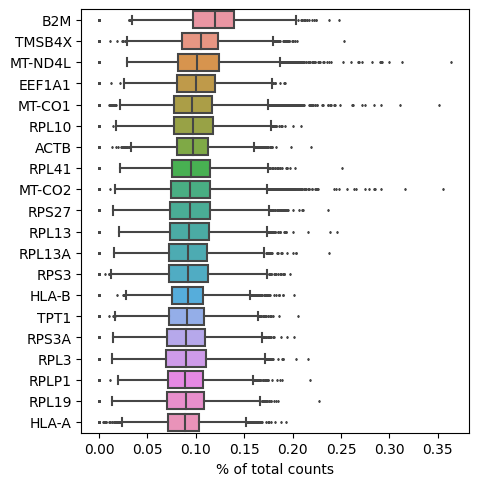

In [23]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [24]:
sc.pp.filter_cells(adata, min_genes=1000) #dont expect to remove any bc these are same thresholds as used in paper
adata

AnnData object with n_obs × n_vars = 16291 × 20645
    obs: 'pid', 'response', 'therapy', 'n_genes'

In [25]:
sc.pp.filter_genes(adata, min_cells=15)
adata

AnnData object with n_obs × n_vars = 16291 × 18136
    obs: 'pid', 'response', 'therapy', 'n_genes'
    var: 'n_cells'

In [26]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

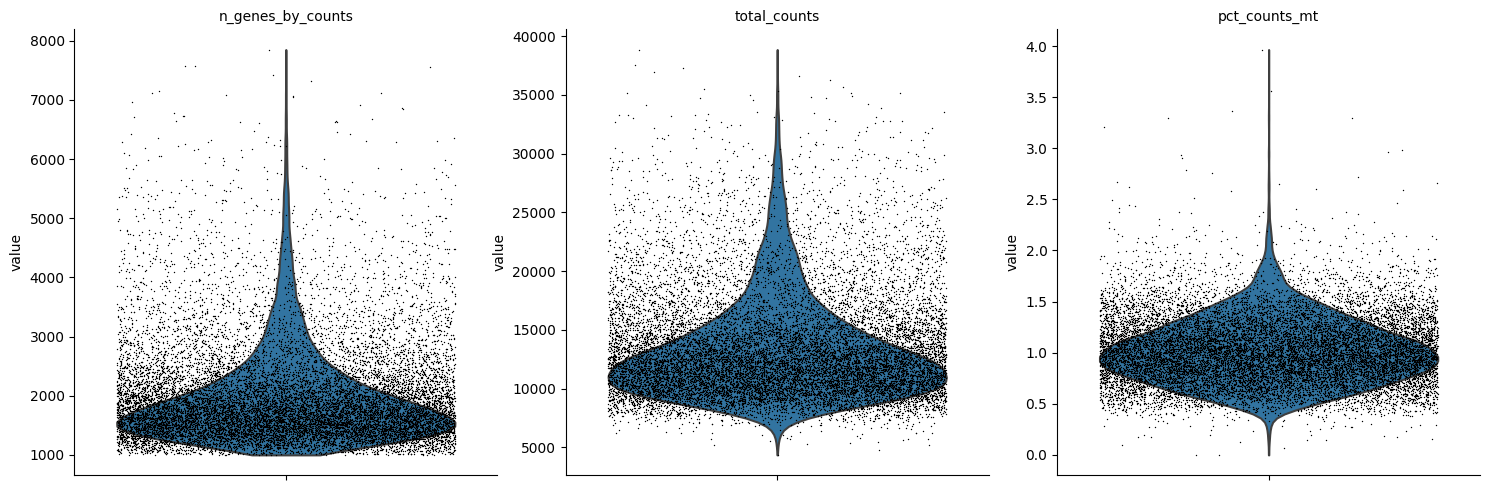

In [27]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

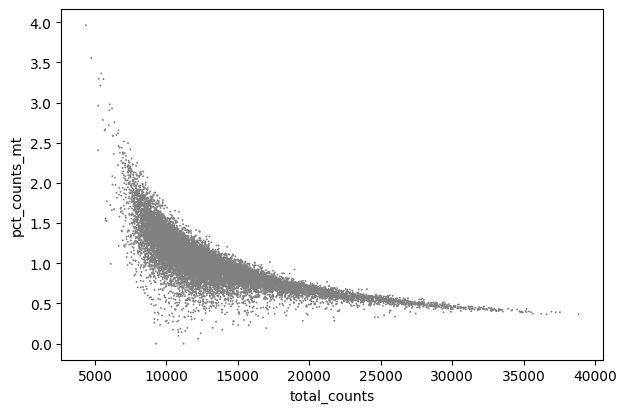

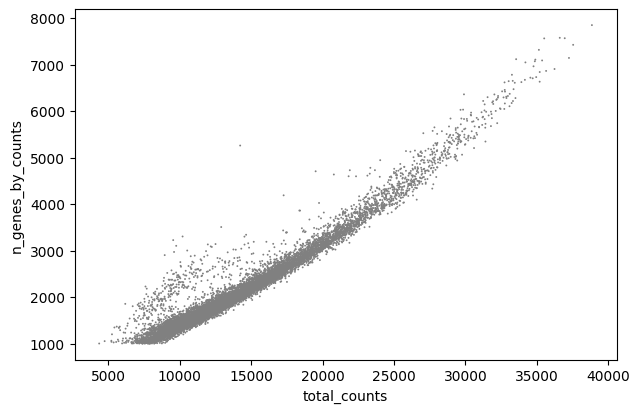

In [28]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

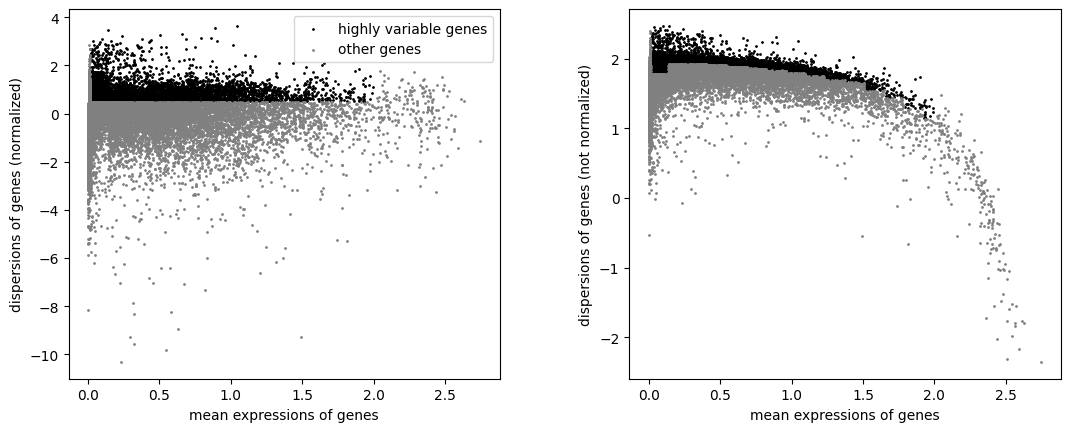

In [29]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=2, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [30]:
#adata.raw = adata
adata.layers['lognorm'] = adata.X.copy()

In [31]:
sc.pp.scale(adata, max_value=10)

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

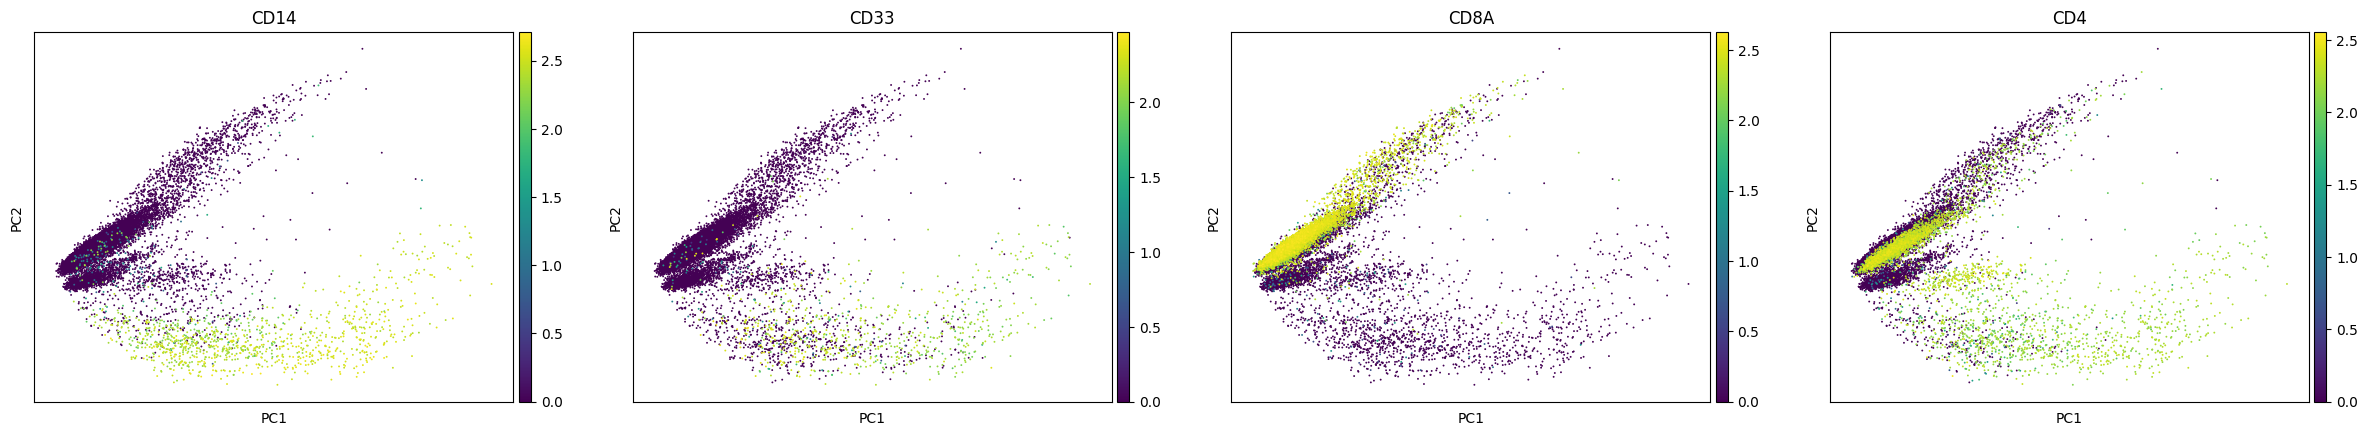

In [33]:
sc.pl.pca(adata, color=['CD14','CD33','CD8A','CD4'])

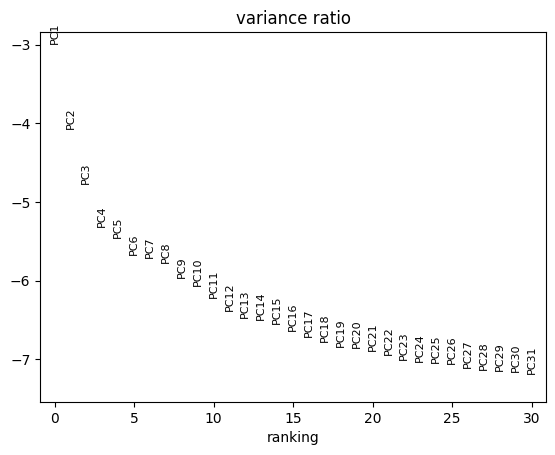

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

In [36]:
sc.tl.umap(adata)

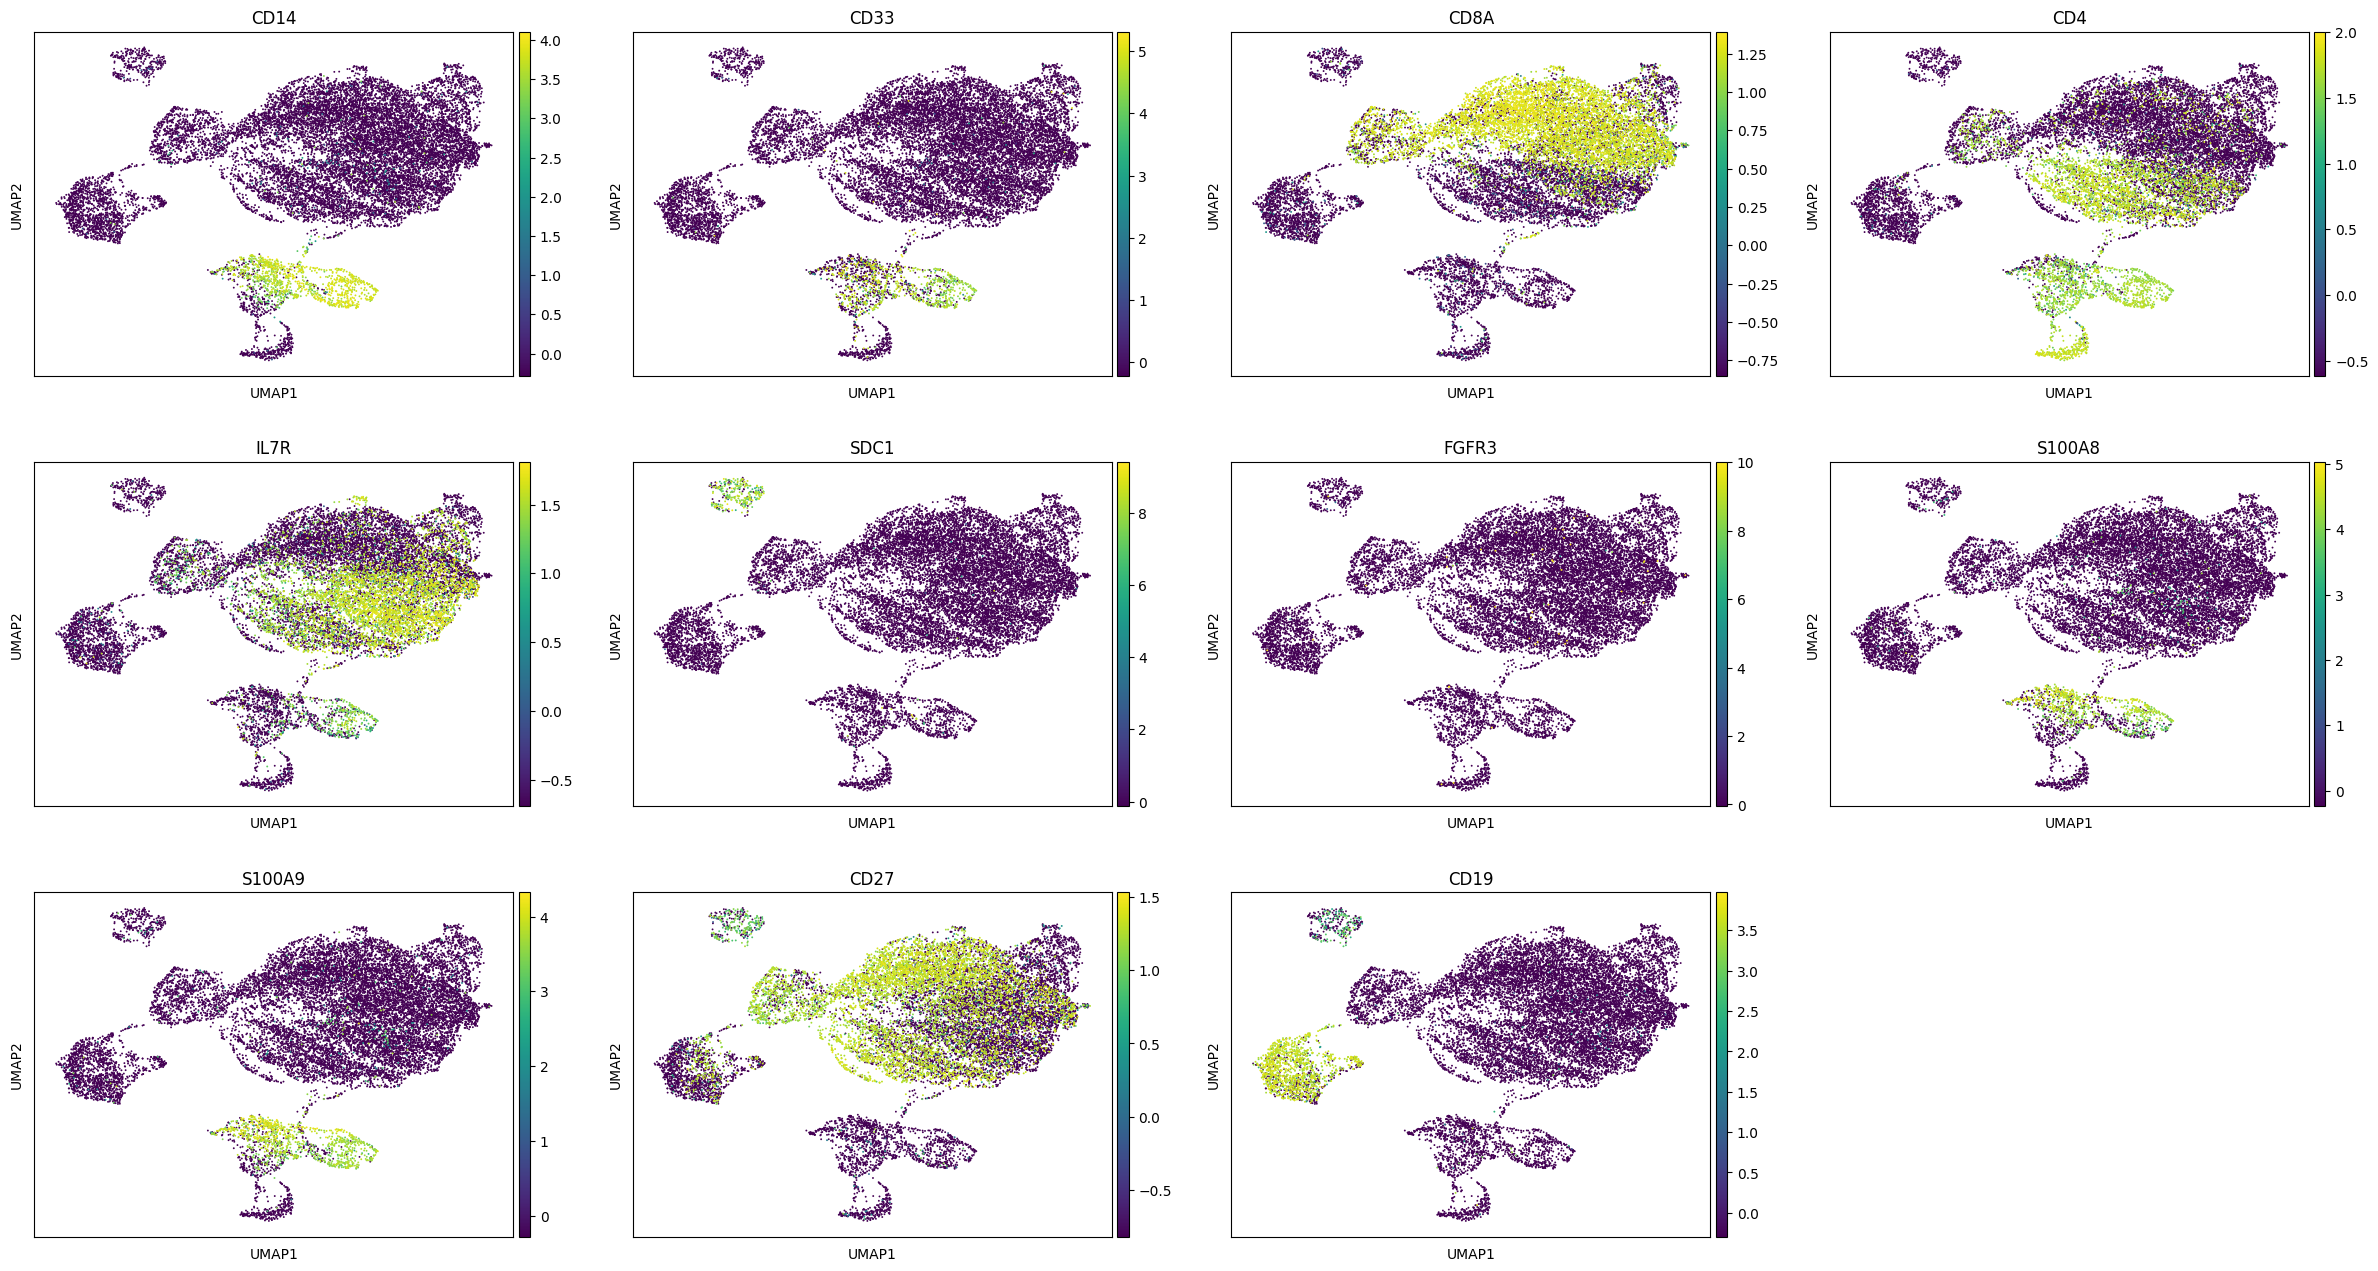

In [69]:
sc.pl.umap(adata, color=['CD14','CD33','CD8A','CD4','IL7R','SDC1','FGFR3','S100A8','S100A9','CD27','CD19'])

/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


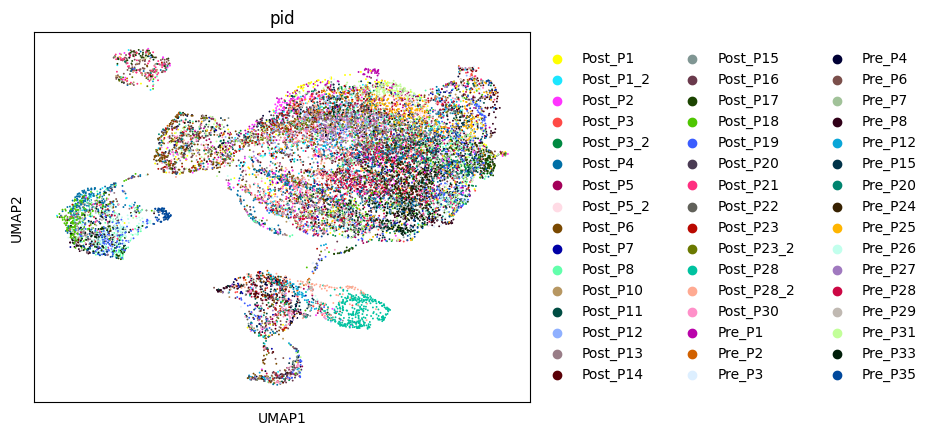

In [70]:
sc.pl.umap(adata, color='pid')

In [37]:
# add additional metadata
adata.obs['pre_or_post'] = [s.split("_")[0] for s in adata.obs.pid]

## write to file

In [76]:
adata.write("/data/rna_rep_learning/sadefeldman/processed_adata_sparse.h5ad")

In [30]:
adata = sc.read("/data/rna_rep_learning/sadefeldman/processed_adata_sparse.h5ad")

# Bootstrap to create semi-synthetic dataset with 600 samples, 350 cells each

In [8]:
#distribution of n cells per patient
print("min", adata.obs.groupby("pid").size().min())
print("median", adata.obs.groupby("pid").size().median())
print("max", adata.obs.groupby("pid").size().max())

min 163
median 337.5
max 675


In [17]:
adata.obs.drop_duplicates("pid").groupby(["response", "pre_or_post", "therapy"]).size()

response       pre_or_post  therapy       
Non-responder  Post         anti-CTLA4         0
                            anti-CTLA4+PD1     3
                            anti-PD1          18
               Pre          anti-CTLA4         1
                            anti-CTLA4+PD1     1
                            anti-PD1           8
Responder      Post         anti-CTLA4         0
                            anti-CTLA4+PD1     3
                            anti-PD1           5
               Pre          anti-CTLA4         1
                            anti-CTLA4+PD1     4
                            anti-PD1           4
dtype: int64

In [38]:
# can sample from groups of patients but they should be homogenous in terms of:
# response (responder or non-responder)
# pre-therapy or post-therapy
# if post-therapy, then should be same therapy (actually, they don't make this distinction in the paper, so nvm)

# creating 4 types of synthetic patients: non-responder pre-therapy (nr_pre), non-responder post-therapy (nr_post; grouping together anti-PD1 and anti-CTLA4+PD1), responder pre-therapy (r_pre), responder post-therapy (r_post; grouping together anti-PD1 and anti-CTLA4+PD1)

n_synthetic = 150 #n synthetic examples to create for each group
n_cells_per_sample = 350 #n cells per synthetic example

nr_pre_idx = np.random.choice(adata[(adata.obs.response == "Non-responder") & (adata.obs.pre_or_post == "Pre")].shape[0], size=n_synthetic*n_cells_per_sample, replace=True)
nr_pre_adata = adata[(adata.obs.response == "Non-responder") & (adata.obs.pre_or_post == "Pre")][nr_pre_idx]

nr_post_idx = np.random.choice(adata[(adata.obs.response == "Non-responder") & (adata.obs.pre_or_post == "Post")].shape[0], size=n_synthetic*n_cells_per_sample, replace=True)
nr_post_adata = adata[(adata.obs.response == "Non-responder") & (adata.obs.pre_or_post == "Post")][nr_post_idx]

r_pre_idx = np.random.choice(adata[(adata.obs.response == "Responder") & (adata.obs.pre_or_post == "Pre")].shape[0], size=n_synthetic*n_cells_per_sample, replace=True)
r_pre_adata = adata[(adata.obs.response == "Responder") & (adata.obs.pre_or_post == "Pre")][r_pre_idx]

r_post_idx = np.random.choice(adata[(adata.obs.response == "Responder") & (adata.obs.pre_or_post == "Post")].shape[0], size=n_synthetic*n_cells_per_sample, replace=True)
r_post_adata = adata[(adata.obs.response == "Responder") & (adata.obs.pre_or_post == "Post")][r_post_idx]

In [39]:
synthetic_adata = nr_pre_adata.concatenate([nr_post_adata, r_pre_adata, r_post_adata], batch_key='synthetic_cat', batch_categories=['nr_pre_adata','nr_post_adata','r_pre_adata','r_post_adata'])

/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. 

In [40]:
#artifically assign patient ids to cells (total of 600 patients)
synthetic_adata.obs['synthetic_pid'] = np.repeat(np.arange(n_synthetic*4)+1, n_cells_per_sample)

In [47]:
# save synthetic adata
synthetic_adata.write("/localdata/rna_rep_learning/sadefeldman/synthetic_data/synthetic_adata.h5ad")

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = '/data/rna_rep_learning/sadefeldman/synthetic_data/synthetic_adata.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [82]:
synthetic_adata = sc.read("/data/rna_rep_learning/sadefeldman/synthetic_data/synthetic_adata.h5ad")

/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# visualize synthetic adata

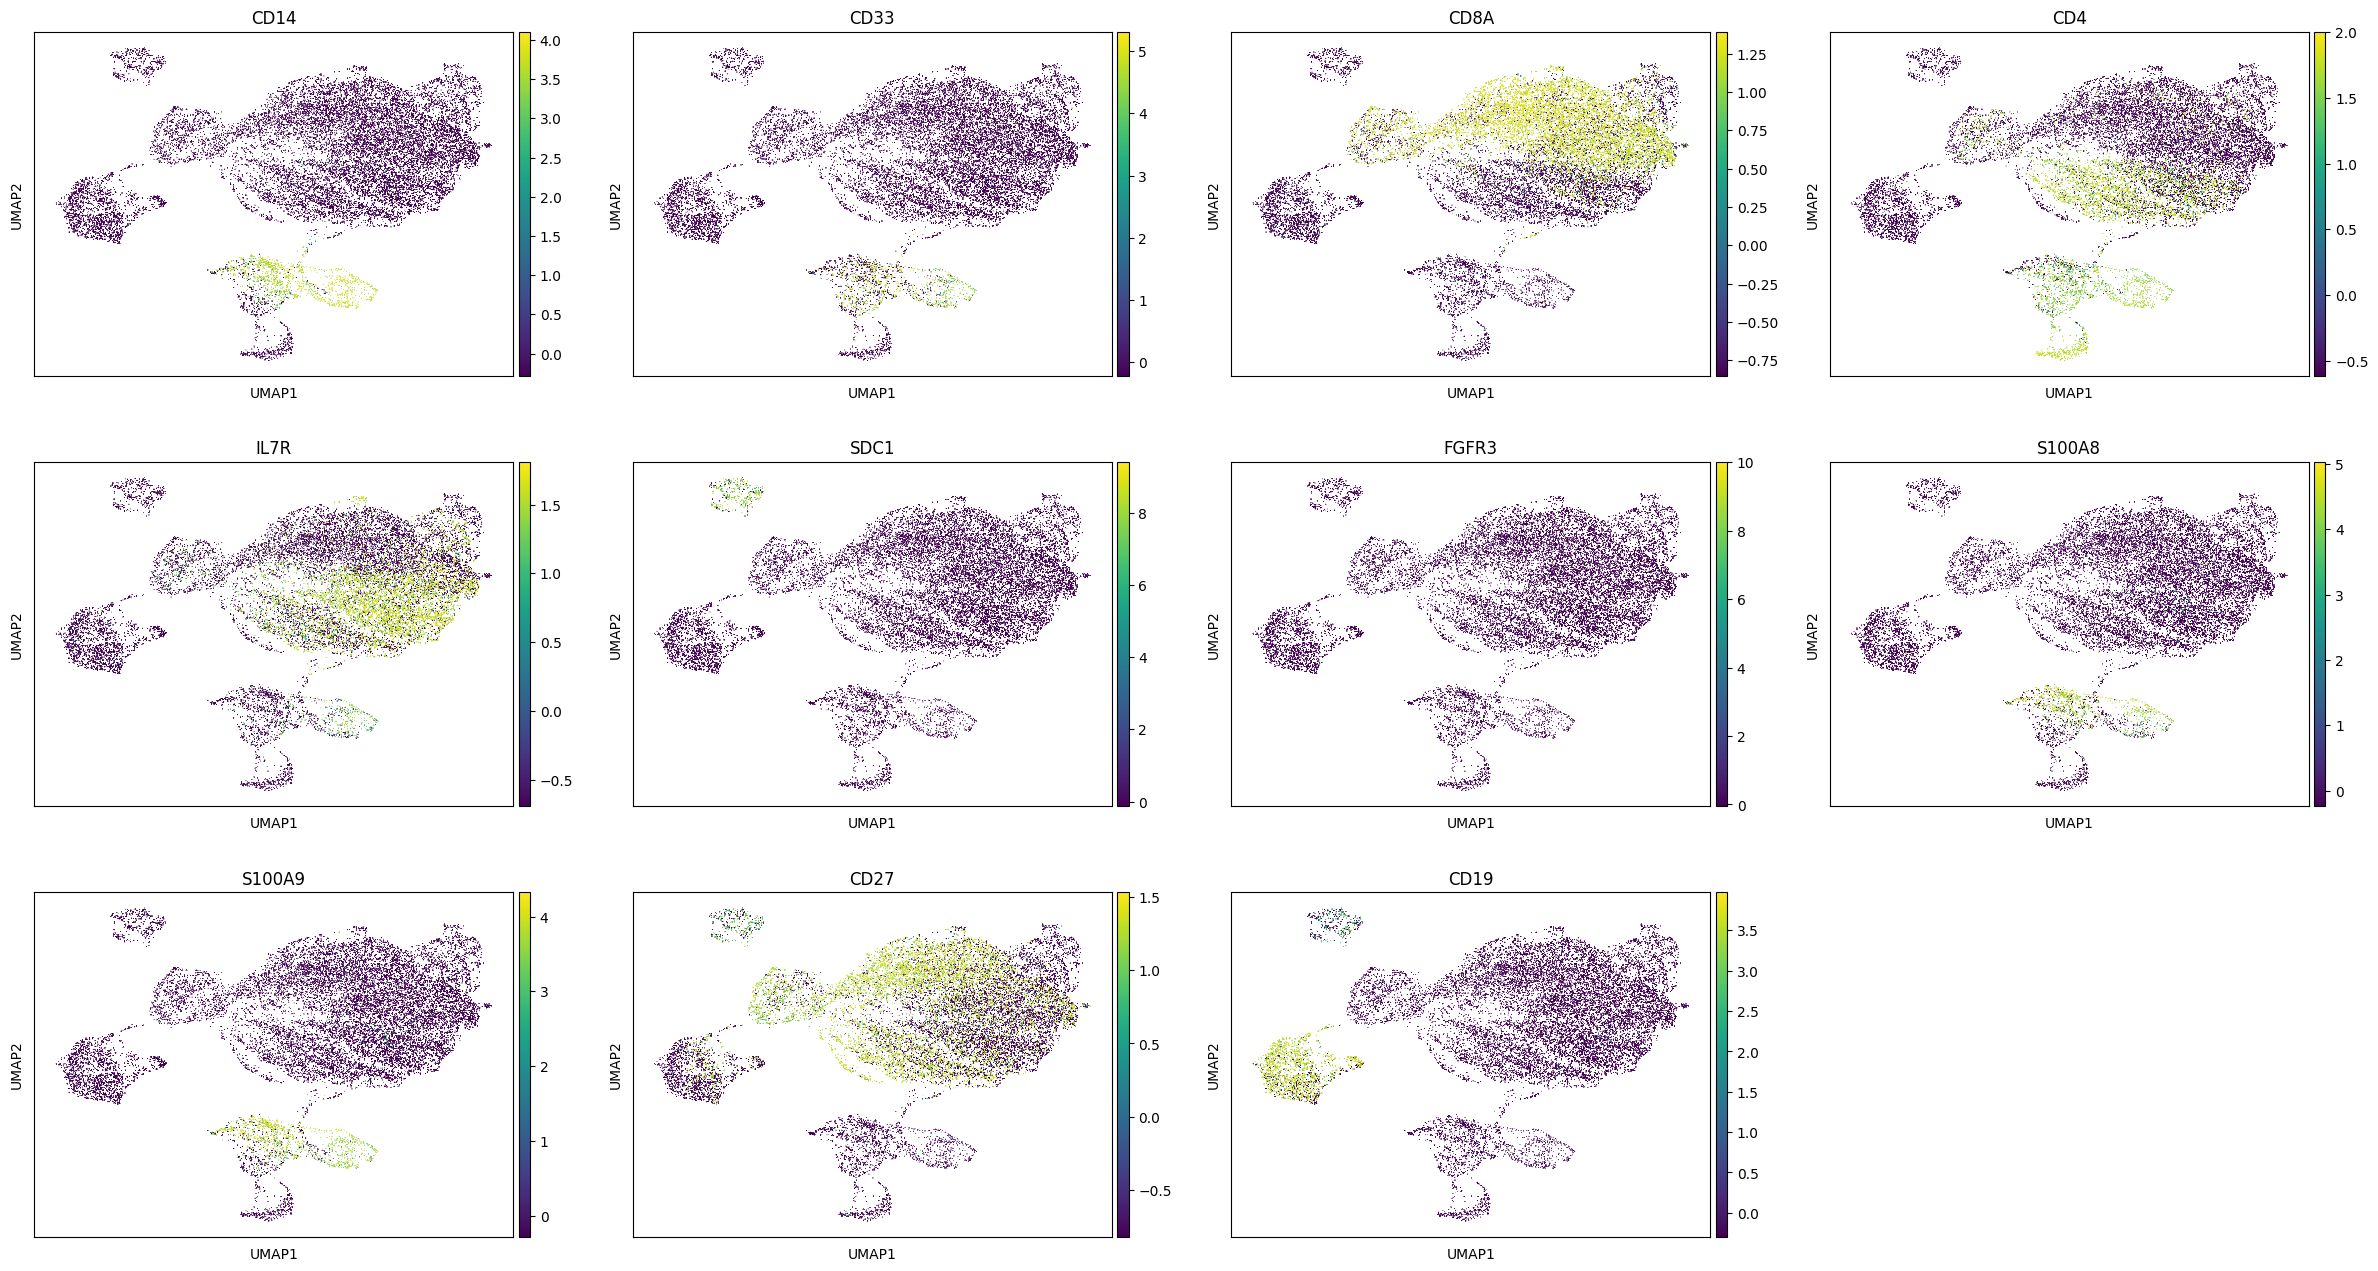

In [83]:
sc.pl.umap(synthetic_adata, color=['CD14','CD33','CD8A','CD4','IL7R','SDC1','FGFR3','S100A8','S100A9','CD27','CD19'])

In [ ]:
#add PCs to obs in order to color by them
synthetic_adata.obs = pd.concat([synthetic_adata.obs, pd.DataFrame(synthetic_adata.obsm['X_pca'][:,:20], columns=["PC"+str(i) for i in range(1,21)], index=synthetic_adata.obs.index)], axis=1)

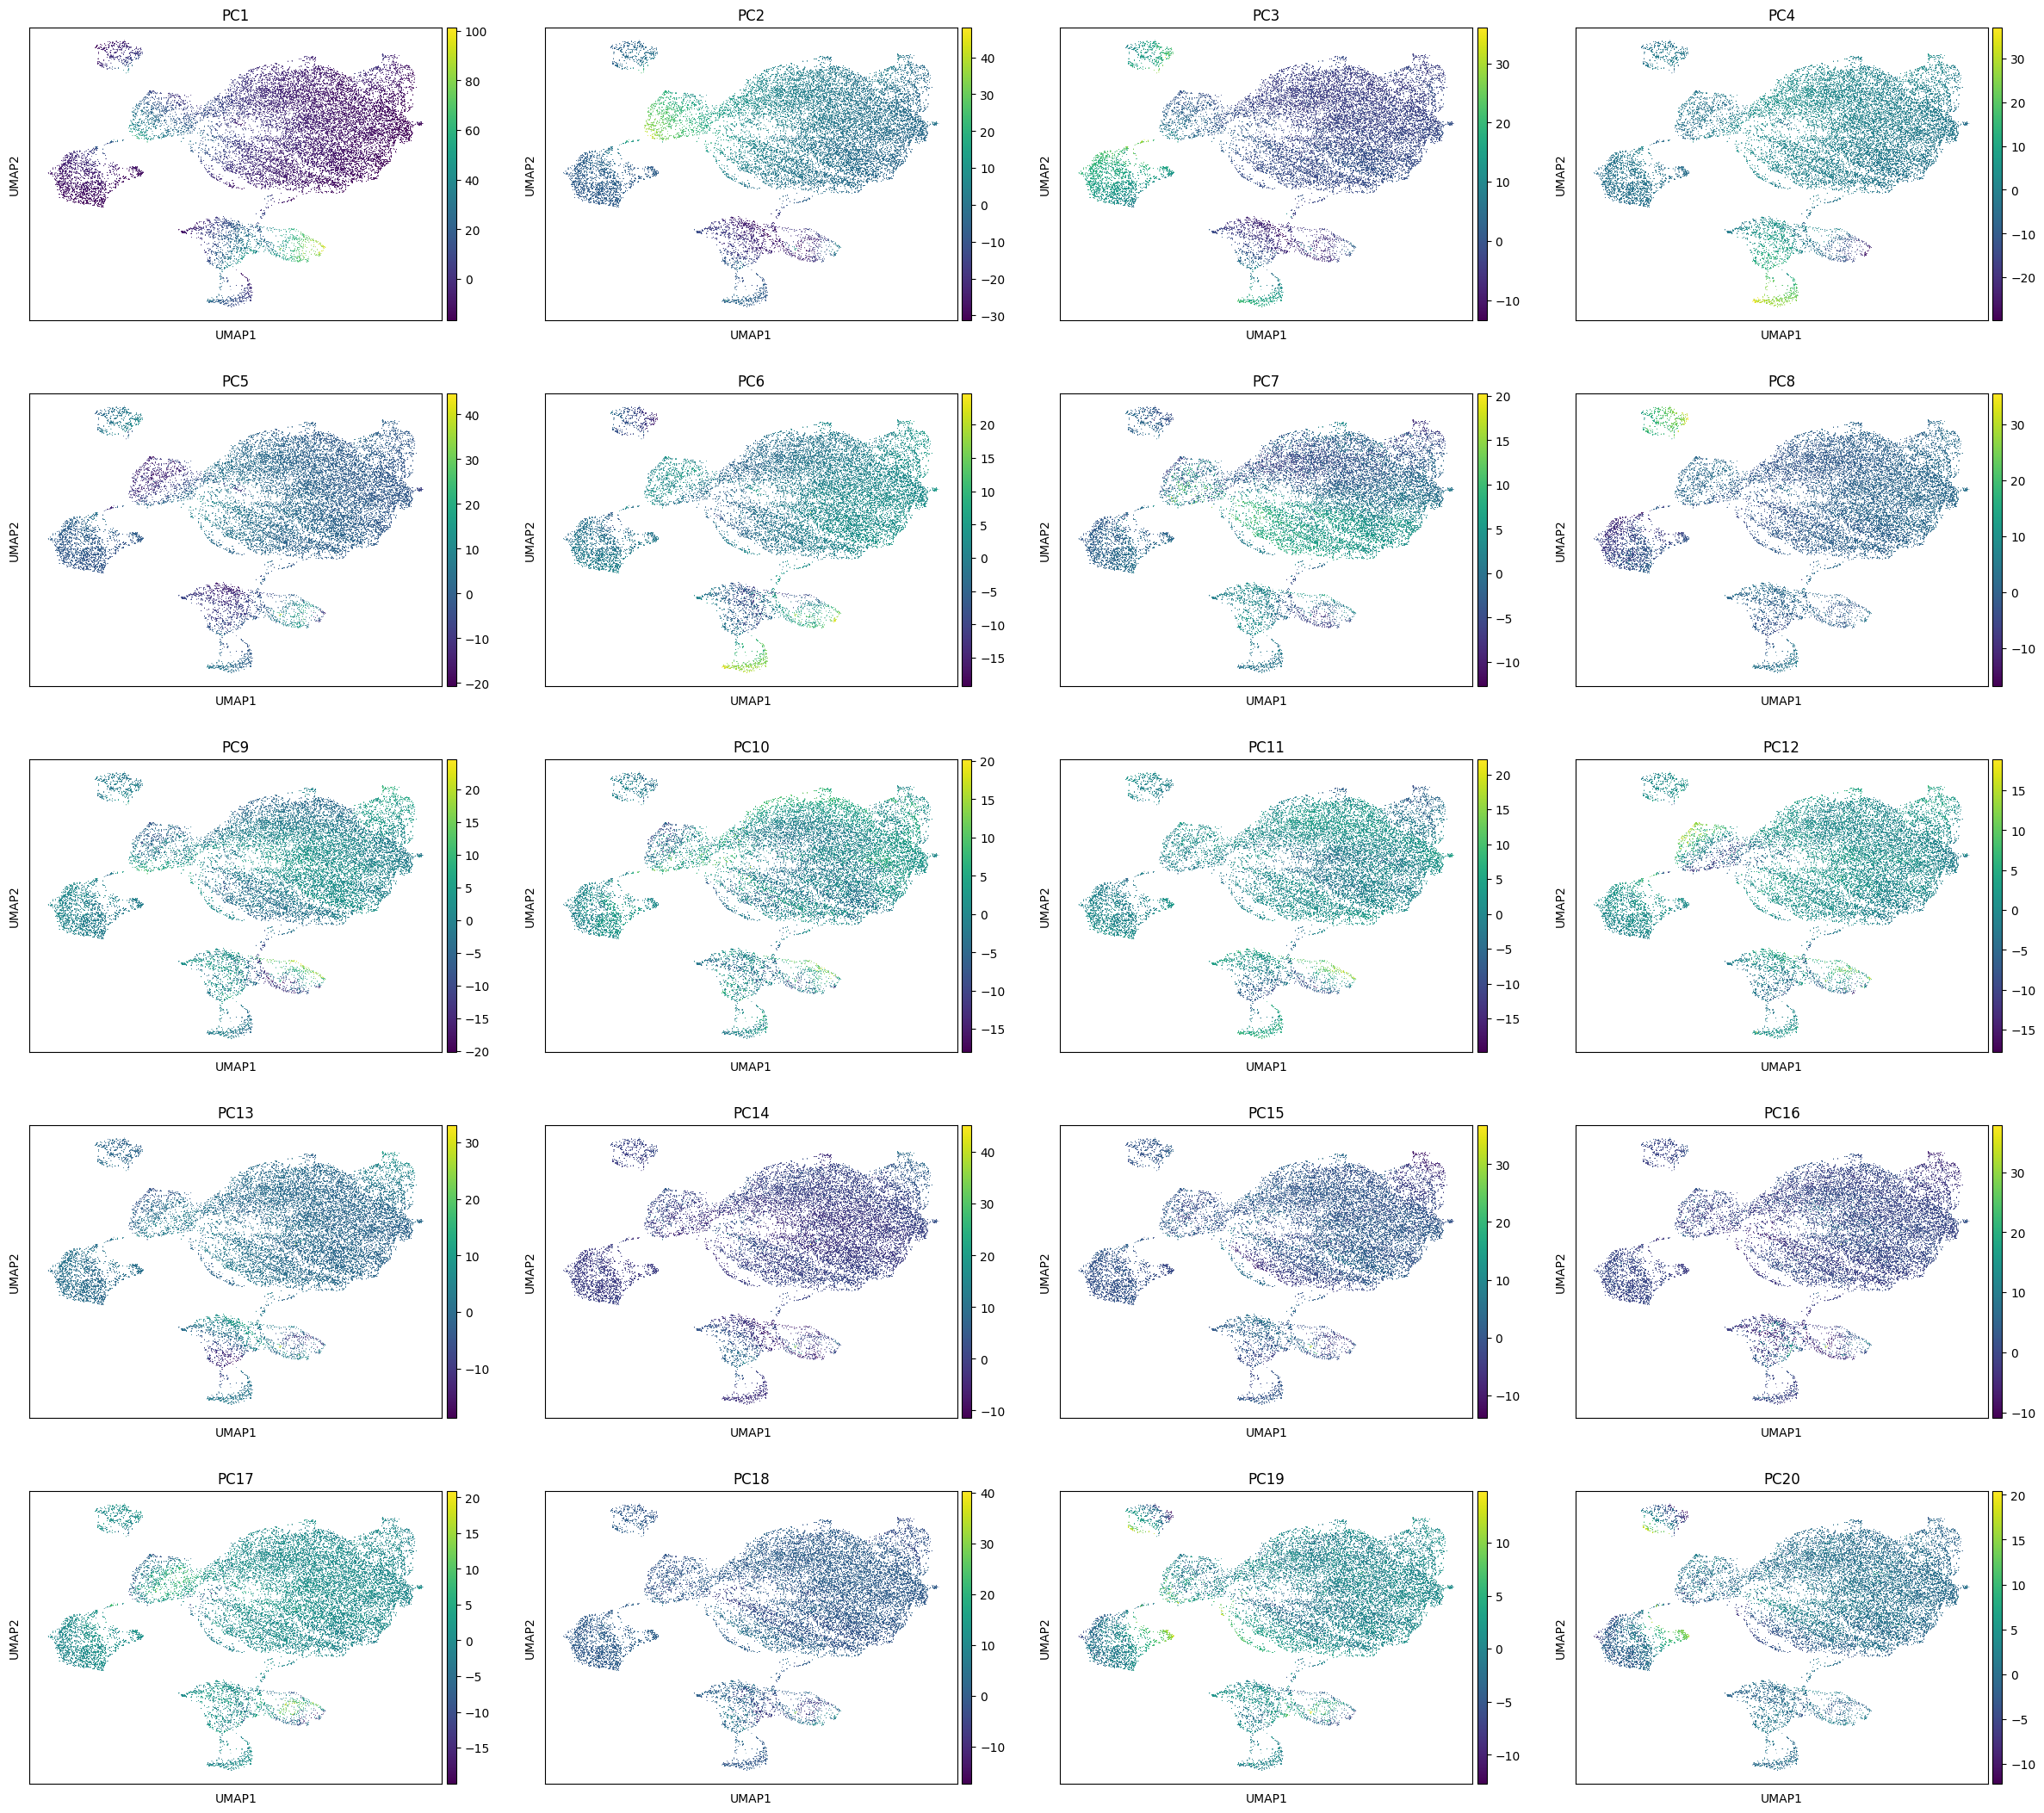

In [26]:
sc.pl.umap(synthetic_adata, color=["PC"+str(i) for i in range(1,21)])

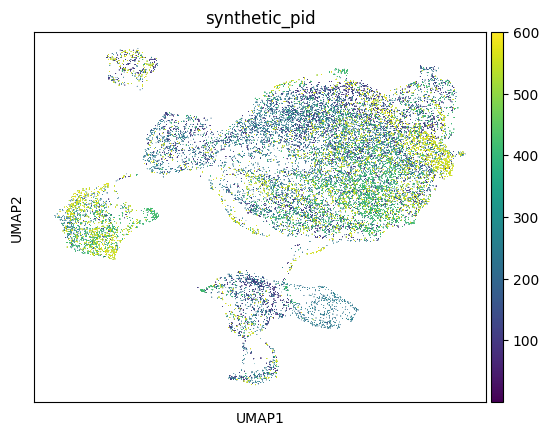

In [46]:
sc.pl.umap(synthetic_adata, color='synthetic_pid')

/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


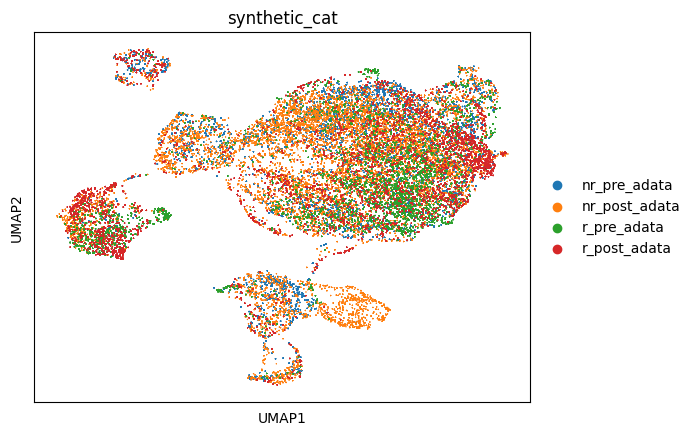

In [50]:
sc.pl.umap(synthetic_adata, color='synthetic_cat', size=3)

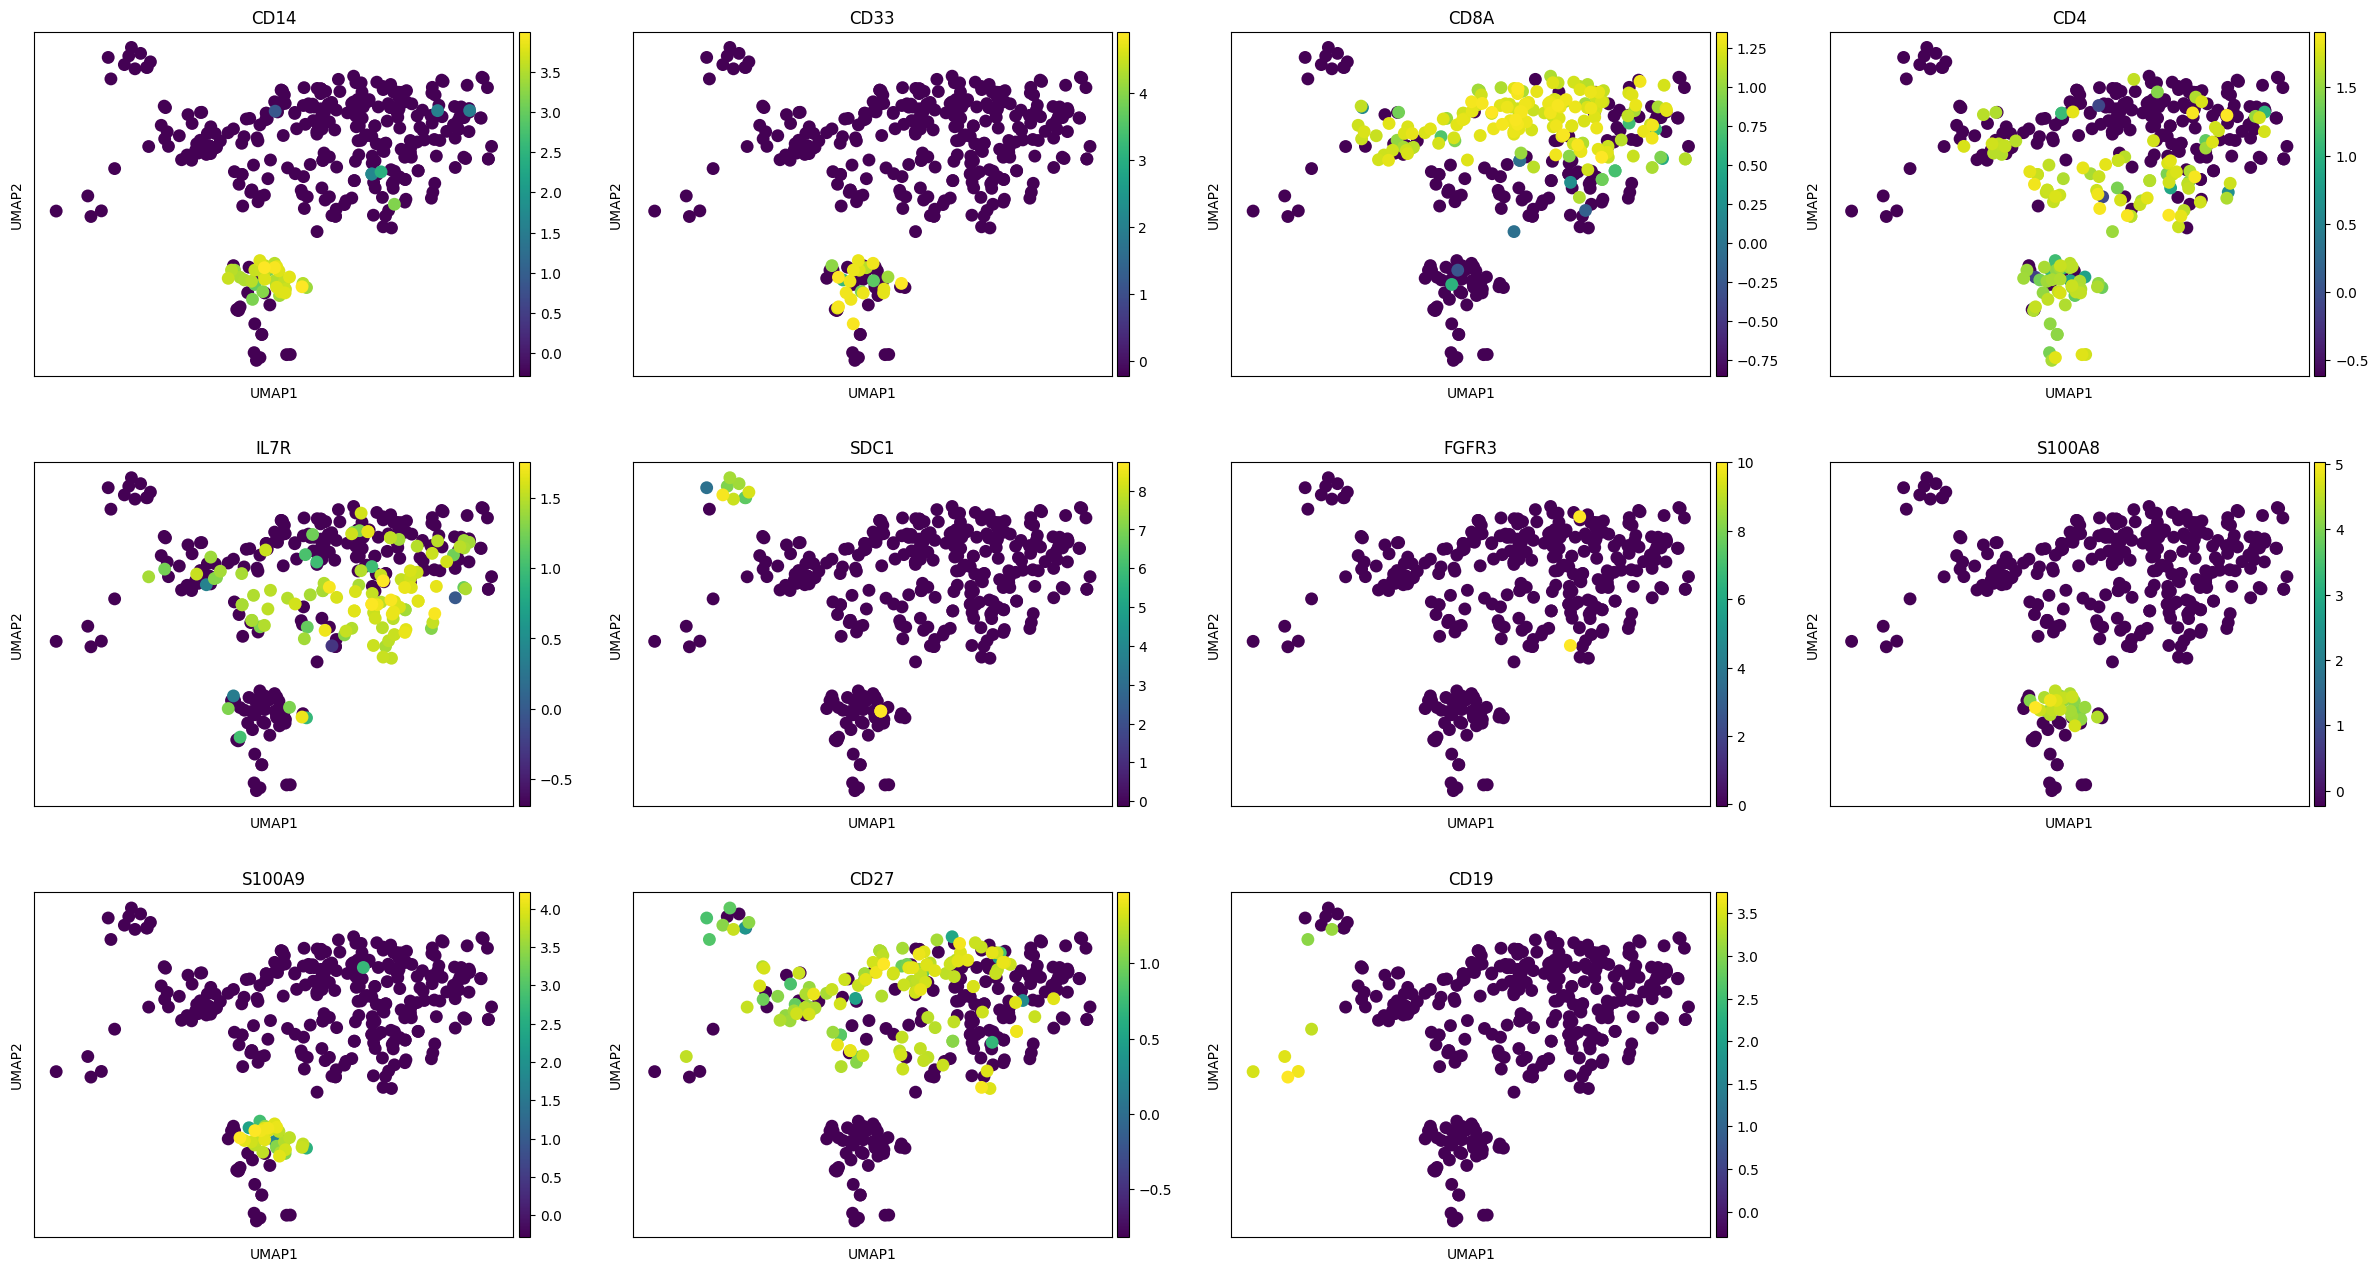

In [51]:
#viz one patient (what we will try to reconstruct)
sc.pl.umap(synthetic_adata[synthetic_adata.obs.synthetic_pid == 1], color=['CD14','CD33','CD8A','CD4','IL7R','SDC1','FGFR3','S100A8','S100A9','CD27','CD19'])

In [84]:
adata.var.highly_variable.sum()

5261